##Libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# For visualization
%matplotlib inline

###Data

In [ ]:
qa_dataset = [
    {
        "question": "What are the admission requirements for Zewail City?",
        "answer": "Admission to Zewail City requires completing secondary education with high scores, passing the admission test, and an interview. International applicants need equivalent qualifications."
    },
    {
        "question": "How can I apply to Zewail City?",
        "answer": "To apply to Zewail City, visit the official website, create an account, fill out the online application form, upload required documents, and pay the application fee."
    },
    {
        "question": "What programs does Zewail City offer?",
        "answer": "Zewail City offers undergraduate and graduate programs in Engineering, Science, and Business. Popular programs include Nanotechnology, Biomedical Sciences, Renewable Energy, and Materials Science."
    },
    {
        "question": "When is the application deadline for Zewail City?",
        "answer": "The standard application deadline for Zewail City is typically in June for the fall semester. Early applications are encouraged as programs may fill up quickly."
    },
    {
        "question": "Is financial aid available at Zewail City?",
        "answer": "Yes, Zewail City offers various financial aid options including scholarships, grants, and work-study programs based on academic merit and financial need."
    },
    {
        "question": "What is the tuition fee for Zewail City?",
        "answer": "Tuition fees at Zewail City vary by program but typically range from 70,000 to 120,000 EGP per academic year. Additional fees apply for laboratory courses and materials."
    },
    {
        "question": "Does Zewail City offer accommodation for students?",
        "answer": "Yes, Zewail City provides on-campus housing facilities for both male and female students, with priority given to international and out-of-town students."
    },
    {
        "question": "What is the minimum GPA required for admission to Zewail City?",
        "answer": "Zewail City typically requires a minimum GPA of 3.2 on a 4.0 scale or 85-90% in secondary education. However, actual requirements may vary by program."
    },
    {
        "question": "Are there any entrance exams for Zewail City?",
        "answer": "Yes, Zewail City requires applicants to take an entrance examination that tests knowledge in mathematics, physics, and English proficiency."
    },
    {
        "question": "Can international students apply to Zewail City?",
        "answer": "Yes, Zewail City welcomes international students. They must provide equivalency certificates for their secondary education qualifications and may need to demonstrate English proficiency."
    }
]


In [2]:


## 2. Dataset Preparation

#We'll create a small dataset of questions and answers related to Zewail City admissions:


# Sample dataset of questions and answers for Zewail City admissions

# Convert to pandas DataFrame for easier handling
df = pd.DataFrame(qa_dataset)
print(f"Dataset size: {len(df)} question-answer pairs")
df.head()

Dataset size: 10 question-answer pairs


,question,answer
0,What are the admission requirements for Zewail...,Admission to Zewail City requires completing s...
1,How can I apply to Zewail City?,"To apply to Zewail City, visit the official we..."
2,What programs does Zewail City offer?,Zewail City offers undergraduate and graduate ...
3,When is the application deadline for Zewail City?,The standard application deadline for Zewail C...
4,Is financial aid available at Zewail City?,"Yes, Zewail City offers various financial aid ..."


##Preprocessing

In [ ]:


def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing to questions
df['processed_question'] = df['question'].apply(preprocess_text)


In [3]:

## 4. Transformer-based Embeddings


#Sentence transformer small model
model_name = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(model_name)

#  embeddings
df['question_embedding'] = list(embedding_model.encode(df['processed_question'].tolist()))

print(f"Embedding dimension: {len(df['question_embedding'][0])}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding dimension: 384


##Siamese

In [4]:


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(SiameseNetwork, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

    def forward_one(self, x):
        # Forward pass for one input
        return self.transform(x)

    def forward(self, x1, x2):
        # Forward pass for both inputs
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

# Set dimensions
embedding_dim = len(df['question_embedding'][0])  # Dimension of the pre-trained embeddings
hidden_dim = 128  # Hidden layer dimension

# Initialize the Siamese network
siamese_net = SiameseNetwork(embedding_dim, hidden_dim)


In [ ]:

##  Contrastive Loss Function


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2)

        # Contrastive loss calculation
        # For similar pairs (label=1), we want to minimize the distance
        # For dissimilar pairs (label=0), we want to maximize the distance, but only up to the margin
        loss_contrastive = torch.mean(
            (label) * torch.pow(euclidean_distance, 2) +  # Similar pairs
            (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  # Dissimilar pairs
        )

        return loss_contrastive


##Interface

In [5]:


## 9. Inference Function for Question Answering

def answer_query(query, df, embedding_model, siamese_net=None, use_siamese=False):

    # Preprocess the query
    processed_query = preprocess_text(query)

    # Generate embedding for the query
    query_embedding = embedding_model.encode([processed_query])[0]

    if use_siamese and siamese_net is not None:
        # Convert to tensor
        query_tensor = torch.tensor(query_embedding, dtype=torch.float32)

        # Get transformed embeddings for query and all questions
        with torch.no_grad():
            # Transform query embedding
            transformed_query = siamese_net.forward_one(query_tensor).numpy()

            # Initialize similarity scores
            similarity_scores = []

            # Calculate similarity with each question embedding
            for q_emb in df['question_embedding']:
                q_tensor = torch.tensor(q_emb, dtype=torch.float32)
                transformed_q = siamese_net.forward_one(q_tensor).numpy()

                # Compute cosine similarity
                similarity = cosine_similarity([transformed_query], [transformed_q])[0][0]
                similarity_scores.append(similarity)
    else:
        # Direct embedding comparison using cosine similarity
        similarity_scores = [cosine_similarity([query_embedding], [q_emb])[0][0]
                           for q_emb in df['question_embedding']]

    # Find the index of the most similar question
    most_similar_idx = np.argmax(similarity_scores)

    # Get the answer and similarity score
    best_match = df.iloc[most_similar_idx]
    answer = best_match['answer']
    original_question = best_match['question']
    similarity = similarity_scores[most_similar_idx]

    return answer, similarity, original_question


In [ ]:
#testing

# Sample queries to test the system
test_queries = [
    "What do I need to apply for Zewail City?",
    "Tell me about the programs at Zewail City",
    "Are there any dorms available?",
    "How much is the tuition?",
    "Can students from other countries apply?",
    "What's the minimum score I need?"
]

# Test each query
for query in test_queries:
    answer, similarity, matched_question = answer_query(query, df, embedding_model, use_siamese=False)

    print(f"Query: {query}")
    print(f"Matched question: {matched_question}")
    print(f"Similarity score: {similarity:.4f}")
    print(f"Answer: {answer}")
    print("-" * 80)

##visualize test

Query: What do I need to apply for Zewail City?
Matched question: How can I apply to Zewail City?
Similarity score: 0.9362
Answer: To apply to Zewail City, visit the official website, create an account, fill out the online application form, upload required documents, and pay the application fee.
--------------------------------------------------------------------------------
Query: Tell me about the programs at Zewail City
Matched question: What programs does Zewail City offer?
Similarity score: 0.8674
Answer: Zewail City offers undergraduate and graduate programs in Engineering, Science, and Business. Popular programs include Nanotechnology, Biomedical Sciences, Renewable Energy, and Materials Science.
--------------------------------------------------------------------------------
Query: Are there any dorms available?
Matched question: Does Zewail City offer accommodation for students?
Similarity score: 0.4200
Answer: Yes, Zewail City provides on-campus housing facilities for both ma

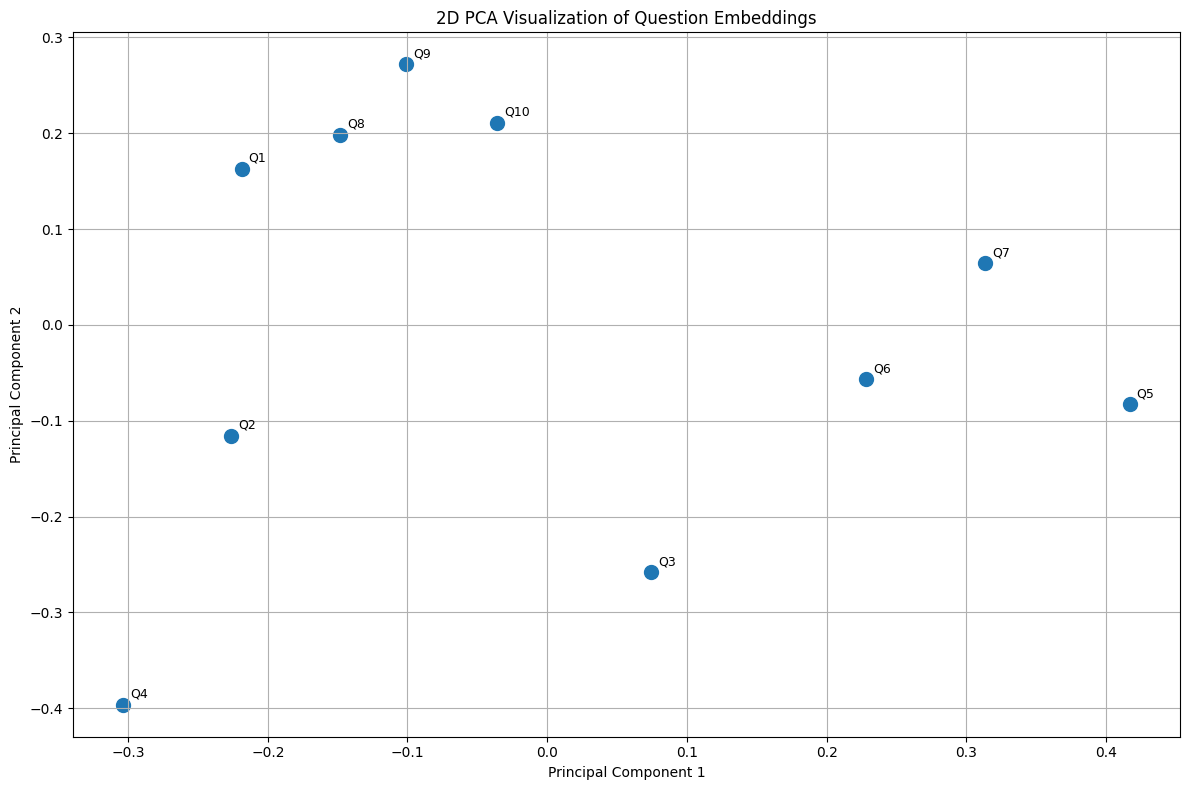

Q1: What are the admission requirements for Zewail Cit...
Q2: How can I apply to Zewail City?
Q3: What programs does Zewail City offer?
Q4: When is the application deadline for Zewail City?
Q5: Is financial aid available at Zewail City?
Q6: What is the tuition fee for Zewail City?
Q7: Does Zewail City offer accommodation for students?
Q8: What is the minimum GPA required for admission to ...
Q9: Are there any entrance exams for Zewail City?
Q10: Can international students apply to Zewail City?


In [6]:


## 11. Visualize Embeddings


# Convert embeddings to numpy array
embeddings = np.array(df['question_embedding'].tolist())

# Use PCA to reduce dimensionality for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o', s=100)

# Add labels for each point
for i, (x, y) in enumerate(reduced_embeddings):
    plt.annotate(f"Q{i+1}", (x, y), fontsize=9,
                 xytext=(5, 5), textcoords='offset points')

plt.title('2D PCA Visualization of Question Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Show a short form of each question for the legend
for i, q in enumerate(df['question']):
    short_q = q[:50] + "..." if len(q) > 50 else q
    print(f"Q{i+1}: {short_q}")


## GUI

In [12]:
def interactive_qa_demo():

    print("Welcome to the Zewail City Admission QA System!")
    print("Ask any question about admissions, or type 'quit' to exit.")
    print("-" * 80)

    while True:
        query = input("\nYour question: ")

        if query.lower() in ['quit', 'exit', 'q']:
            print("Thank you for using the Zewail City Admission QA System!")
            break

        answer, similarity, matched_question = answer_query(query, df, embedding_model)

        print("\nResults:")
        print(f"Most similar question: {matched_question}")
        print(f"Similarity score: {similarity:.4f}")
        print(f"Answer: {answer}")

In [8]:
interactive_qa_demo()

Welcome to the Zewail City Admission QA System!
Ask any question about admissions, or type 'quit' to exit.
--------------------------------------------------------------------------------

Your question: how to apply to zewail city

Results:
Most similar question: How can I apply to Zewail City?
Similarity score: 0.9924
Answer: To apply to Zewail City, visit the official website, create an account, fill out the online application form, upload required documents, and pay the application fee.

Your question: q
Thank you for using the Zewail City Admission QA System!


In [13]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [14]:
import gradio as gr

In [20]:
import gradio as gr
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time
from typing import Tuple, List, Optional

PRIMARY_COLOR = "#0d47a1"  # Deep blue
SECONDARY_COLOR = "#e3f2fd"  # Light blue background
ACCENT_COLOR = "#1e88e5"    # Accent blue

# Sample dataset (replace with your actual QA dataset)
qa_dataset = [
    {"question": "What are the admission requirements?", "answer": "You need a high school diploma and passing grades in science subjects."},
    {"question": "When is the application deadline?", "answer": "The deadline is July 31st each year."},
    {"question": "What majors are offered?", "answer": "Majors include Engineering, Science, and Nanotechnology."},
    {"question": "How much is the tuition fee?", "answer": "Tuition is approximately $5000 per year."},
    {"question": "Are scholarships available?", "answer": "Yes, merit-based scholarships are available."},
]

# Initialize DataFrame and embedding model
df = pd.DataFrame(qa_dataset)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Preprocess questions and generate embeddings
df['processed_question'] = df['question'].str.lower()  # Basic preprocessing
df['question_embedding'] = df['processed_question'].apply(lambda x: embedding_model.encode(x))

def answer_query(query: str, df: pd.DataFrame, embedding_model) -> Tuple[str, float, str]:

    # Preprocess the query
    processed_query = query.lower()
    query_embedding = embedding_model.encode(processed_query)

    # Compute cosine similarity between query and dataset questions
    similarity_scores = [cosine_similarity([query_embedding], [q_emb])[0][0] for q_emb in df['question_embedding']]

    # Find the most similar question
    most_similar_idx = np.argmax(similarity_scores)
    best_match = df.iloc[most_similar_idx]

    return (
        best_match['answer'],
        similarity_scores[most_similar_idx],
        best_match['question']
    )

def gradio_answer_query(query: str, history: List) -> Tuple[str, List]:

    if not query.strip():
        return "", history

    # Simulate processing time (remove in production)
    time.sleep(0.5)

    # Get answer from the QA system
    answer, similarity, matched_question = answer_query(query, df, embedding_model)

    # Format response based on confidence levels
    if similarity >= 0.8:
        confidence_indicator = "🟢 High confidence"
        explanation = f"Your question closely matches: \"{matched_question}\""
    elif similarity >= 0.6:
        confidence_indicator = "🟡 Medium confidence"
        explanation = f"Your question somewhat matches: \"{matched_question}\""
    else:
        confidence_indicator = "🔴 Low confidence"
        explanation = f"Your question vaguely matches: \"{matched_question}\""
        answer += "\n\nFor better results, try rephrasing your question or contact admissions directly at admissions@zewailcity.edu.eg"

    formatted_response = f"""
### {confidence_indicator}
{explanation}

**Answer:**
{answer}
"""

    return formatted_response, history + [[query, formatted_response]]

def clear_chat() -> Tuple[List, str]:
    return [],

# Example FAQs for the sidebar - pulled from the dataset
EXAMPLE_QUESTIONS = df['question'].tolist()

def create_interface() -> gr.Blocks:

    with gr.Blocks(theme=gr.themes.Default(
        primary_hue="blue",
        secondary_hue="blue",
        neutral_hue="gray"
    )) as demo:
        gr.Markdown(
            """
            # Zewail City Admission QA System

            Get answers to your questions about admissions at Zewail City University.
            """
        )

        with gr.Row():
            with gr.Column(scale=3):
                # Chat interface
                chatbot = gr.Chatbot(
                    label="Conversation",
                    height=450,
                    bubble_full_width=False,
                    show_copy_button=True
                )

                with gr.Row():
                    query_input = gr.Textbox(
                        placeholder="Type your question about Zewail City admissions...",
                        label="Your Question",
                        lines=2,
                        show_label=False
                    )
                    submit_btn = gr.Button("Ask", variant="primary")

                with gr.Row():
                    clear_btn = gr.Button("Clear Chat")
                    download_btn = gr.Button("Download Transcript")

            with gr.Column(scale=1):
                # Sidebar with helpful information
                gr.Markdown("### Example Questions")

                example_buttons = [gr.Button(question, size="sm") for question in EXAMPLE_QUESTIONS]

                gr.Markdown("### About")
                gr.Markdown(
                    """
                    This system provides information about:
                    - Admission requirements
                    - Application process
                    - Available programs
                    - Tuition and fees
                    - Scholarships and financial aid

                    For more information, visit [Zewail City Website](https://www.zewailcity.edu.eg)
                    """
                )

                gr.Markdown("### Contact Admissions")
                gr.Markdown("📧 admissions@zewailcity.edu.eg\n📞 +20 123456789")

        # Set up event handlers
        submit_btn.click(
            fn=gradio_answer_query,
            inputs=[query_input, chatbot],
            outputs=[query_input, chatbot]
        )

        query_input.submit(
            fn=gradio_answer_query,
            inputs=[query_input, chatbot],
            outputs=[query_input, chatbot]
        )

        clear_btn.click(
            fn=clear_chat,
            inputs=[],
            outputs=[chatbot, query_input]
        )

        # Connect example question buttons
        for btn in example_buttons:
            btn.click(
                fn=lambda q: (q, []),
                inputs=[btn],
                outputs=[query_input, chatbot]
            ).then(
                fn=gradio_answer_query,
                inputs=[query_input, chatbot],
                outputs=[query_input, chatbot]
            )



    return demo

if __name__ == "__main__":
    demo = create_interface()
    demo.launch(share=True)

<ipython-input-20-d531de746fd8>:128: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
<ipython-input-20-d531de746fd8>:128: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://219f8f784ad0c638d8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
